In [1]:
!unzip -o -q /content/training.zip -d /content/palm
%cd /content/palm/PALM-Training400/
!unzip -o -q PALM-Training400.zip
!unzip -o -q /content/validation.zip -d /content/palm 
!unzip -o -q /content/valid_gt.zip -d /content/palm 
%cd /content/


/content/palm/PALM-Training400
/content


In [4]:
!pwd

/content


In [2]:
import pandas as pd

# Load the Excel file
excel_file = '/content/palm/PALM-Validation-GT/PM_Label_and_Fovea_Location.xlsx'
df = pd.read_excel(excel_file)

# Save as CSV
csv_file = '/content/palm/PALM-Validation-GT/labels.csv'
df.to_csv(csv_file, index=False)


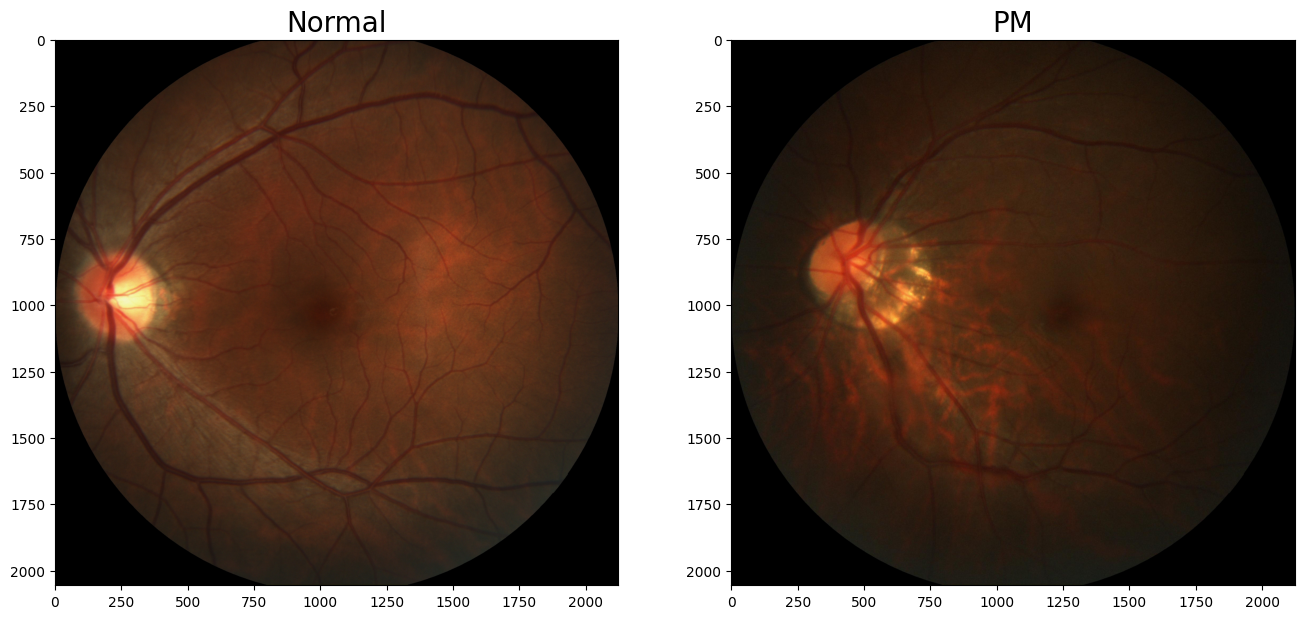

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

datadir="/content/palm/PALM-Training400/PALM-Training400"
#N is normal, P is palm
file1="N0011.jpg"
file2="P0094.jpg"

#read image and show image
img1 = Image.open(os.path.join(datadir, file1))
img1 = np.array(img1)
img2 = Image.open(os.path.join(datadir, file2))
img2 = np.array(img2)


plt.figure(figsize=(16, 8))
f = plt.subplot(121)
f.set_title('Normal', fontsize=20)
plt.imshow(img1)
f = plt.subplot(122)
f.set_title('PM', fontsize=20)
plt.imshow(img2)
plt.show()


In [4]:
img1.shape,img2.shape

((2056, 2124, 3), (2056, 2124, 3))

In [5]:
# Image Preprocessing
import cv2
import numpy as np

def transform_img(img):
  # resize
  img=cv2.resize(img,(224,224))
  # transpose image format from[H,W,C] to [C,H,W]
  img=np.transpose(img,(2,0,1))
  # typecast
  img=img.astype('float32')
  # normalization
  img=img/225
  # rescale format the range to [-1,1]
  # [0,1]-[0,2]-[-1,1]
  img=img*2.0-1.0
  return img

# Resize
The resizing of images to a size of 224x224 is often done in computer vision and machine learning tasks because many pre-trained models, such as VGG16 or ResNet, were originally trained on ImageNet data, where images were resized to this dimension. Using the same image size allows for these pre-trained models to be easily applied to new tasks via transfer learning, taking advantage of the weights already learned on ImageNet.

In terms of selecting an appropriate size for your image resizing, this largely depends on the specific requirements of your task, the nature of the data you're working with, and the computational resources you have available. Here are a few factors to consider:

1. **Task Requirements:** If the details in the image are important for your task, a larger image size might be more suitable. For example, if you're trying to identify subtle features in medical images, a higher resolution might be necessary.

2. **Data Nature:** If your images are naturally large and detailed, reducing them to a small size might lose critical information. Similarly, if your images are naturally small, upsampling them to a large size might introduce unnecessary noise.

3. **Computational Resources:** Training deep learning models on large images requires a lot of computational resources. If resources are limited, it might be more practical to resize images to a smaller size.

4. **Pre-Trained Models:** If you plan to use a pre-trained model, you'll need to resize your images to the size that the pre-trained model expects. Many models trained on ImageNet expect 224x224, but other sizes are also common, like 299x299 for InceptionNet or 448x448 for some versions of YOLO.

5. **Uniformity:** It's common practice to resize images so they all have the same dimensions, as most deep learning models expect uniform input sizes.

In terms of 3D images or volumes (like medical images), the same considerations apply, but you're now dealing with an additional dimension. For example, a 3D convolutional neural network might take as input a 64x64x64 volume. It's important to remember that increasing the size of the input exponentially increases the computational resources needed, so careful consideration must be given when working with 3D data. Additionally, the aspect ratio of the original data should be maintained to prevent distortion.

Remember to experiment and validate: try different image sizes and see which works best for your specific task in terms of performance, speed, and resource usage.


### Why power of 2
The sizes of 64, 128, 256, etc., are powers of 2. This choice is not arbitrary and is rooted in the way that computers, and more specifically GPUs, handle data.

A few reasons for this are:

1. **Memory alignment:** Computers are very good at handling data in chunks that are powers of 2. For example, memory is often aligned to 4-byte (32-bit) or 8-byte (64-bit) boundaries for efficient access. Using sizes that are powers of 2 can align with this and potentially allow for more efficient memory access.

2. **Hardware optimizations:** Modern GPU architectures, which are typically used to train deep learning models, are optimized for operations with dimensions that are powers of 2. Using sizes like 64, 128, 256, etc., can lead to significant speedup in training.

3. **Ease of scaling:** It's easier to scale layers in a neural network when their sizes are powers of 2. For example, halving or doubling the size of a layer can be done simply by shifting bits, which is faster and more efficient.

4. **Convolutions:** In the case of convolutional neural networks, using filter sizes that are powers of 2 allows the spatial dimensions of the input to be halved with each layer in a predictable manner. This makes it easier to design networks that gradually reduce the spatial dimensions while increasing the depth.

While there might be no theoretical issue with using sizes like 200 or 100, it might lead to inefficiencies in memory usage and speed of operations due to the reasons mentioned above. However, as always, it's important to validate assumptions with experimentation. It's possible that for certain tasks or datasets, using non-standard sizes might give better performance.


In [6]:
#Define data loader in cv2 
#not used
import cv2
import random
import numpy as np
import os

def data_loader(datadir,batch_size=10,mode='train'):
  filenames=os.listdir(datadir)
  def reader():
    if mode=='train':
      random.shuffle(filenames)
    batch_img=[]
    batch_label=[]
    for name in filenames:
      filepath=os.path.join(datadir,name)
      img=cv2.imread(filepath)
      img=transform_img(img)
      if name[0]=='H' or name[0]=='N':
        #high shortsightedness or normal
        label=0
      elif name[0]=='P':
        label=1
      else:
        raise('Not excepted file name')

      #save the label and img dataset
      batch_img.append(img)
      batch_label.append(label)

      if len(batch_img)==batch_size:
        #mini_batch return
        imgs_array=np.array(batch_img).astype('float32')
        labels_array=np.array(batch_label).reshape(-1,1)
        yield imgs_array,labels_array
        batch_img=[]
        batch_label=[]

    if len(batch_img)>0:
      #keep remaining as batch
      imgs_array=np.array(batch_img).astype('float32')
      labels_array=np.array(batch_label).reshape(-1,1)
      yield imgs_array,labels_array
    
    return reader

def valid_data_loader(datadir, csvfile,batch_size=10,mode='valid'):
  filelists=open(csvfile).readlines()
  def reader():
      batch_img = []
      batch_label = []
      for line in filelists[1:]:
          line = line.strip().split(',')
          name = line[1]
          label = int(line[2])
          # 根据图片文件名加载图片，并对图像数据作预处理
          filepath = os.path.join(datadir, name)
          img = cv2.imread(filepath)
          img = transform_img(img)
          # 每读取一个样本的数据，就将其放入数据列表中
          batch_img.append(img)
          batch_label.append(label)
          if len(batch_img) == batch_size:
              imgs_array = np.array(batch_img).astype('float32')
              labels_array = np.array(batch_label).reshape(-1, 1)
              yield imgs_array, labels_array
              batch_imgs = []
              batch_labels = []
      if len(batch_img)>0:
      #keep remaining as batch
      imgs_array=np.array(batch_img).astype('float32')
      labels_array=np.array(batch_label).reshape(-1,1)
      yield imgs_array,labels_array

  return reader
    
  


IndentationError: ignored

In [7]:
# torch version
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import random
import torch.nn.functional as F

#Define transform: resize, convert to tensor and nomalization
#Normalizes the tensor with mean and standard deviation, and 3 channel
transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                              transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])

#Define traindataset, custom Pytorch dataset
class TrainDataset(Dataset):
  def __init__(self, datadir,transform=None):
    self.datadir =datadir
    self.filenames=os.listdir(datadir)
    random.shuffle(self.filenames)
    self.transform=transform

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self,idx):
  #loads and transforms image from file
    filepath=os.path.join(self.datadir,self.filenames[idx])
    img=Image.open(filepath)
    if self.transform:
      img=self.transform(img)
    if self.filenames[idx][0] == 'H' or self.filenames[idx][0] == 'N':
      label = 0
    elif self.filenames[idx][0] == 'P':
      label = 1
    else:
      raise Exception('Not expected file name')
    return img, label


class ValidDataset(Dataset):
    def __init__(self, datadir, csvfile, transform=None):
        self.datadir = datadir
        self.df = pd.read_csv(csvfile)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
    #get label from csv file
        filepath = os.path.join(self.datadir, self.df.loc[idx, 'imgName'])
        img = Image.open(filepath)
        if self.transform:
            img = self.transform(img)
        label = int(self.df.loc[idx, 'Label'])
        return img, label


def data_loader(datadir, csvfile=None, batch_size=10, mode='train', transform=None):
    if mode == 'train':
        dataset = TrainDataset(datadir, transform)
    elif mode == 'valid':
        dataset = ValidDataset(datadir, csvfile, transform)
    else:
        raise Exception('Not expected mode')
    return DataLoader(dataset, batch_size=batch_size, shuffle=(mode=='train'))

In [11]:
train_loader = data_loader(datadir,batch_size=10, mode='train',transform=transform)
data = next(iter(train_loader))
print(data[0].shape, data[1].shape)


valid_loader=data_loader("/content/palm/PALM-Validation400",csvfile='/content/palm/PALM-Validation-GT/labels.csv', batch_size=10, mode='valid',transform=transform)
data=next(iter(valid_loader))
print(data[0].shape,data[1].shape)


torch.Size([10, 3, 224, 224]) torch.Size([10])
torch.Size([10, 3, 224, 224]) torch.Size([10])


In [12]:
#load resnet
from torchvision.models import resnet50


model = resnet50()
#replace the final layer to 2 output
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

#pytorch crossentropyloss combines a softmax operation and a log loss operation
loss_fn = nn.CrossEntropyLoss()


In [19]:
#Handle training and evaluating 
class Runner(object):
  def __init__(self,model,optimizer,loss_fn):
    #define the constructor, and keep track on these elements
    self.model= model
    self.optimizer=optimizer
    self.loss_fn=loss_fn
    # Keep track of the best accuracy
    self.best_acc=0


  def train_pm(self,train_datadir,val_datadir,csvfile,**kwargs):
    print('start training ......')
    #check GPU
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    #move model to GPU/CPU
    self.model=self.model.to(device)
    #set model in training mode
    self.model.train()
    #read in train and valid dataset
    train_loader=data_loader(train_datadir,batch_size=10, mode='train',transform=transform)
    valid_loader=data_loader(val_datadir,csvfile=csvfile, batch_size=10, mode='valid',transform=transform)

    #set up the num_epochs, if no input, then 0
    num_epochs=kwargs.get('num_epoch',0)#the argument name is num_epoch
    #setup the saving path, if no input, then '/content/palm'
    save_path=kwargs.get('save_path','/content/palm')

    #training process
    for epoch in range(num_epochs):
      for batch, data in enumerate(train_loader):
        x,y=data
        x,y=x.to(device), y.to(device)
        self.optimizer.zero_grad()
        output=self.model(x)
        loss=self.loss_fn(output,y)
        if batch%20==0:
          print('epoch: {}, batch id: {}, loss is: {}'.format(
              epoch,batch,loss))
        loss.backward()
        self.optimizer.step()
      #calculate the accuracy after each epoch
      acc=self.evaluate_pm(valid_loader)
      #set model back to train mode
      self.model.train()
      #save the best model
      if acc > self.best_acc:
        torch.save(self.model.state_dict(), os.path.join(save_path, 'model.pth'))
        self.best_acc=acc


  #accuracy validation function
  def evaluate_pm(self,valid_loader):
    #model evaluation mode
    self.model.eval()
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    accuracy=[]
    losses=[]
    #not to construct the computation graph
    with torch.no_grad():
      for batch, data in enumerate(valid_loader):
        x,y=data
        x,y=x.to(device),y.to(device)
        output=self.model(x)
        #converts the output to probability scores for each class
        pred=F.softmax(output,dim=1)
        loss=self.loss_fn(output,y)
        # Calculate accuracy
        _, predicted = torch.max(pred, 1)  # get the index of the max log-probability
        correct = (predicted == y).float()  # convert into float for division 
        acc = correct.sum() / len(correct)
        accuracy.append(acc.item())
        losses.append(loss.item())
    accuracy_tensor = torch.tensor(accuracy)  # Convert list of floats to PyTorch tensor
    loss_tensor = torch.tensor(losses)
    print(f"[validation] accuracy/loss: {torch.mean(accuracy_tensor):.4f}/{torch.mean(loss_tensor):.4f}")
    return torch.mean(accuracy_tensor)


  def predict_pm(self,x,**kwargs):
      #run model on single input and return the prediction
      self.model.eval()
      with torch.no_grad():
        output = self.model(x)
      return output


  def load_model(self,model_path):
      self.model.load_state_dict(torch.load(model_path))

 * Why no need softmax during training: the cross-entropy loss function often includes the softmax operation, so applying softmax explicitly before the cross-entropy loss is not necessary and could potentially lead to numerical instability in the calculations.

 * During evaluation, you usually want to interpret the model's raw output scores as probabilities

 #### Raw score or probability:
 whether to return probabilities (softmax applied) or logits (raw scores) would depend on the downstream tasks. If you simply need to know the most likely prediction, the raw scores would be enough since softmax doesn't change the order of the scores. However, if you need the output to represent valid probability distributions (all positive and sum up to 1), then you should apply softmax.

In [21]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu") 
opt=torch.optim.SGD(model.parameters(),lr=0.001)
runner=Runner(model,opt,loss_fn)

In [15]:
datadir="/content/palm/PALM-Training400/PALM-Training400"
datadir2="/content/palm/PALM-Validation400"
CSVFILE='/content/palm/PALM-Validation-GT/labels.csv'

epoch_num=5
PATH='/content/palm'
if not os.path.exists(PATH):
    os.makedirs(PATH)



In [17]:
runner.train_pm(datadir,datadir2,num_epoch=10,csvfile=CSVFILE,save_path=PATH)

start training ......
epoch: 0, batch id: 0, loss is: 0.5046342015266418
epoch: 0, batch id: 20, loss is: 0.6381800770759583
[validation] accuracy/loss: 0.8450/0.4830
epoch: 1, batch id: 0, loss is: 0.5387613773345947
epoch: 1, batch id: 20, loss is: 0.47637516260147095
[validation] accuracy/loss: 0.8500/0.4599
epoch: 2, batch id: 0, loss is: 0.4430697560310364
epoch: 2, batch id: 20, loss is: 0.646189272403717
[validation] accuracy/loss: 0.9150/0.4112
epoch: 3, batch id: 0, loss is: 0.4641250669956207
epoch: 3, batch id: 20, loss is: 0.39315977692604065
[validation] accuracy/loss: 0.7975/0.4421
epoch: 4, batch id: 0, loss is: 0.3652229905128479
epoch: 4, batch id: 20, loss is: 0.5694966912269592
[validation] accuracy/loss: 0.8075/0.4448
epoch: 5, batch id: 0, loss is: 0.423565536737442
epoch: 5, batch id: 20, loss is: 0.4474828839302063
[validation] accuracy/loss: 0.8850/0.3714
epoch: 6, batch id: 0, loss is: 0.31608885526657104
epoch: 6, batch id: 20, loss is: 0.6188596487045288
[val

The true category is 0 and the predicted category is 0


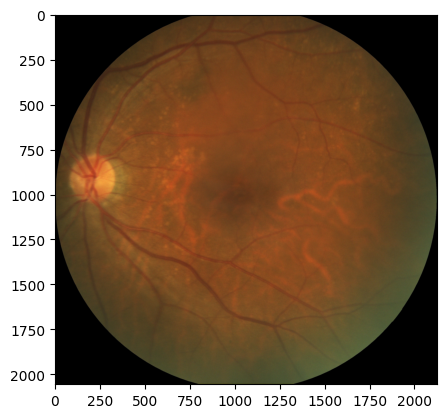

In [22]:
# Check the best model

#load the best model
runner.load_model('/content/palm/model.pth')

#get the first data from validation dataset
filelists = open(CSVFILE).readlines()

# You can get other test images by modifying the number in the filelists list(1-400)
line = filelists[25].strip().split(',')
name, label = line[1], int(line[2])

#read the test image
used_img=Image.open(os.path.join(datadir2,name))
#preprocess the test
test_img=transform(used_img)

# Switch to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_img = test_img.to(device)

#Model prediction
#the model expect a batch of image, add extra dimention to the test_img
logits=runner.predict_pm(test_img.unsqueeze(0))
result=F.softmax(logits,dim=1)
pred_class=torch.argmax(result).item()

# Output real category and predicted category
print("The true category is {} and the predicted category is {}".format(label, pred_class))

# Image visualization
# Convert the tensor to numpy array and transpose the color channel to the last dimension
plt.imshow(used_img)
plt.show()


## **kwargs
In Python, `**kwargs` is a special syntax that's used in function signatures and function calls to pass a variable-length list of keyword arguments. `kwargs` is short for 'keyword arguments'.

When defining a function, you might not know beforehand how many arguments the function needs to accept. In such cases, you can use `*args` for variable-length non-keyword arguments and `**kwargs` for variable-length keyword arguments.

Here's an example function that uses `**kwargs`:

```python
def print_key_value_pairs(**kwargs):
    for key, value in kwargs.items():
        print(f"{key} = {value}")
```

You can call this function with any number of keyword arguments:

```python
print_key_value_pairs(name="John", age=25, country="USA")
```

And it will output:

```
name = John
age = 25
country = USA
```

`kwargs` inside the function is a dictionary that holds the passed keyword arguments. `kwargs.items()` returns key-value pairs from the dictionary.

`kwargs.get(key, default_value)` is a method provided by the dictionary type in Python. It tries to get the value of a key from the dictionary. If the key is not found in the dictionary, it returns the `default_value` provided. If `default_value` is not provided, it defaults to `None`.

Here's an example:

```python
def greet(**kwargs):
    name = kwargs.get('name', 'stranger')
    print(f"Hello, {name}!")
```

Calling `greet(name='John')` will output `Hello, John!`, while calling `greet()` (with no arguments) will output `Hello, stranger!`. In the latter case, since 'name' is not provided in `kwargs`, `kwargs.get('name', 'stranger')` returns `'stranger'`.

Remember, while `kwargs` is a commonly used name for this concept, you could use any valid variable name instead of `kwargs`. The important part is the `**` prefix.